# Импорт

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image as Image

import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

from LookGenerator.datasets.person_segmantation_dataset import PersonSegmentationDataset, PersonSegmentationDatasetMultichannel
from LookGenerator.networks.segmentation import UNet, train_unet
from LookGenerator.networks.utils import load_model
import LookGenerator.datasets.transforms as custom_transforms
from LookGenerator.datasets.utils import prepare_image_for_model_transpose, to_array_from_model_transpose, show_array_multichannel
from LookGenerator.datasets.utils import prepare_image_for_model_transpose, to_array_from_model_bin_transpose


# Загрузка данных

In [2]:
transform_input = transforms.Compose([
    transforms.Resize((256, 192)),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.25, 0.25, 0.25]
    )
])

transform_output = transforms.Compose([
    transforms.Resize((256, 192)),
    custom_transforms.MinMaxScale(),
    custom_transforms.ThresholdTransform(threshold=0.5)
])

In [3]:
batch_size_train = 32
batch_size_val = 16

In [4]:
train_dataset = PersonSegmentationDataset("C:\\Users\\DenisovDmitrii\\Desktop\\train", transform_input=transform_input, transform_mask=transform_output)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
len(train_dataloader)

92

In [5]:
val_dataset = PersonSegmentationDataset("C:\\Users\\DenisovDmitrii\\Desktop\\test", transform_input=transform_input, transform_mask=transform_output)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size_val, shuffle=False)
len(val_dataloader)

59

Test load train_dataloader. and val.

torch.Size([32, 3, 256, 192])
torch.Size([32, 1, 256, 192])


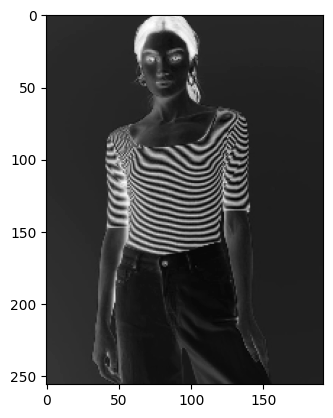

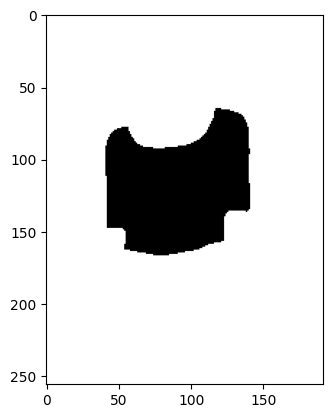

In [6]:
for X, y in train_dataloader:
    print(X.shape)
    print(y.shape)
    plt.imshow(X.detach().numpy()[0,0,:,:], cmap = 'binary')
    plt.show()
    plt.imshow(y.detach().numpy()[0,0,:,:], cmap = 'binary')
    plt.show()
    # modelled_img = to_array_from_model_bin_transpose(transform_output(X.detach()))
    # plt.imshow(modelled_img,cmap = 'binary')
    # plt.show()
    # modelled_img = to_array_from_model_bin_transpose(transform_output(y.detach()))
    # plt.imshow(modelled_img,cmap = 'binary')
    # plt.show()
    break

# Обучение модели

Метки классов на изображении:

1. Левое лицо                       248,251,14
2. Правое лицо                      251,235,25
3. Туловище                         20,80,194
4. Внешняя верхняя левая рука       190,189,96
5. Внешняя верхняя правая рука      215,187,88
6. Внешняя нижняя левая рука        252,206,48
7. Внешняя нижняя правая рука       250,220,36
8. Внутренняя верхняя левая рука    145,191,116
9. Внутренняя верхняя правая рука   170,190,105
10. Внетренняя нижняя левая рука     228,191,74
11. Внутренняя нижняя правая рука    240,198,60
12. Левая кисть                      8,110,221
13. Правая кисть                     4,98,224
14. Левая нога                       22,173,184
15. Правая нога                      6,166,198

In [7]:
model = UNet(in_channels=3, out_channels = 1)
#model = load_model(model, r'C:\Users\DenisovDmitrii\Desktop\segmentation_weits\session12\asd.pt')
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [8]:
import datetime
now = datetime.datetime.now()
print("start time", now.strftime("%d-%m-%Y %H:%M"))

train_history, val_history = train_unet(
    model,
    train_dataloader,
    val_dataloader,
    optimizer,
    device=device,
    epoch_num=15,
    save_directory="C:\\Users\\DenisovDmitrii\\Desktop\\segmentation_weits\\session22"
)
old = now
now = datetime.datetime.now()
print("end time", now.strftime("%d-%m-%Y %H:%M"))
print("delta", now - old)


start time 24-02-2023 13:22



KeyboardInterrupt



In [ ]:
model = load_model(model, r'C:\Users\Даша\PycharmProjects\SMBackEnd\LookGenerator\weights\unet_epoch_0_0.0161572862694324.pt')
model.eval()